In [98]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import random
import time

import torch
import torchvision
import numpy as np
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.utils.data as data
from torchvision import datasets, models, transforms
import json
import copy
import seaborn as sns
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt

In [99]:
!pip install progressbar

In [100]:
import urllib.request
import progressbar
from os.path import exists

class ProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar=progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()
if not exists("./flower_data.tar.gz"):
    urllib.request.urlretrieve(" https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz", "flower_data.tar.gz", ProgressBar())
if not exists("./cat_to_name.json"):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/Muhammad-MujtabaSaeed/102-Flowers-Classification/master/cat_to_name.json", "cat_to_name.json",  ProgressBar())

In [101]:
import io
import os
import tarfile

def get_file_progress_file_object_class(on_progress):
    class FileProgressFileObject(tarfile.ExFileObject):
        def read(self, size, *args):
            on_progress(self.name, self.position, self.size)
            return tarfile.ExFileObject.read(self, size, *args)
    return FileProgressFileObject

class TestFileProgressFileObject(tarfile.ExFileObject):
    def read(self, size, *args):
        on_progress(self.name, self.position, self.size)
        return tarfile.ExFileObject.read(self, size, *args)

class ProgressFileObject(io.FileIO):
    def __init__(self, path, *args, **kwargs):
        self._total_size = os.path.getsize(path)
        io.FileIO.__init__(self, path, *args, **kwargs)

    def read(self, size):
        print(f"\rOverall process: [{self.tell()/self._total_size * 100:3.2f} %]", end='')
        return io.FileIO.read(self, size)

def on_progress(filename, position, total_size):
    print("%s: %d of %s" %(filename, position, total_size))

if not exists("./flowers"):
    tarfile.TarFile.fileobject = get_file_progress_file_object_class(on_progress)
    tar = tarfile.open(fileobj=ProgressFileObject("flower_data.tar.gz"))
    tar.extractall('./flowers')
    tar.close()

In [102]:
# Ensure deterministic behavior
def init_seeds(seed=0):
    torch.manual_seed(seed) # sets the seed for generating random numbers.
    torch.backends.cudnn.deterministic = True

init_seeds(1)
# Device configuration
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 3060 Laptop GPU


In [103]:
!pip install wandb

In [104]:
import wandb

wandb.login()
os.environ["WANDB_API_KEY"] = "x"*40
project_name = "Deep_Learning_HW1_Flowers102"
test_code = "offline"  # "online" or "disabled"

config = dict(
    epochs          = 45,
    batch_size      = 32,
    learning_rate   = 0.1,
    gamma           = 0.1,
    step_size       = 30,
    classes         = 102,
    dataset         = "Flowers102",
    model           = "resnet18",
    activation      = "relu",     # leaky relu/sigmoid/elu/tanh/relu
    optimizer       = "SGD",
)
data_dir = './flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [105]:
# defining data transforms for training, validation and test data and also normalizing whole data
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomRotation(45),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=config['batch_size'], shuffle=True, num_workers=4)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [106]:
import json
#
with open('./cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# changing categories to their actual names 
for i in range(0,len(class_names)):
    class_names[i] = cat_to_name.get(class_names[i])

In [107]:
import torch.optim as optim

def make(config):
    # loading a pre-trained(trained on image net) resnet18 model from torchvision models
    model_ft = models.resnet18(pretrained=False) 
    model_ft.layer1[0].relu = nn.ReLU()
    model_ft.layer1[1].relu = nn.ReLU()
    model_ft.layer2[0].relu = nn.ReLU()
    model_ft.layer2[1].relu = nn.ReLU()
    model_ft.layer3[0].relu = nn.ReLU()
    model_ft.layer3[1].relu = nn.ReLU()
    model_ft.layer4[0].relu = nn.ReLU()
    model_ft.layer4[1].relu = nn.ReLU()

    num_ftrs = model_ft.fc.in_features
    # changing the last layer for this dataset by setting last layer neurons to 102 as this dataset has 102 categories
    model_ft.fc = nn.Linear(num_ftrs, 102) 
    model_ft.to(device)

    # defining loss function
    criterion = nn.CrossEntropyLoss() 
     # defining optimizer with learning rate set to 0.0001
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=config.learning_rate,
                             momentum=0.9, weight_decay=0.0001)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=config.step_size, gamma=config.gamma)
    
    return model_ft, criterion, optimizer_ft, scheduler

In [108]:
def test_model(model, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes['test']
        epoch_acc = running_corrects.double() / dataset_sizes['test']
        print('\n\n' + '-' * 10)
        print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc*100:.4f}%')

In [109]:
def train_model(model, criterion, optimizer, scheduler, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)
    

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = 0
    running_loss_list = []
    since = time.time()
    for epoch in range(config.epochs):
        print("\n")
        print(f'Epoch {epoch}/{config.epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase]):
                inputs = data[0].to(device)
                labels = data[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print(f"\rBatch:{i+1:03} of {len(dataloaders[phase])}, lr:{scheduler.get_last_lr()[0]:1.10f}", end='')
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            running_loss_list.append(epoch_loss)
            print(f'\n{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc*100:.4f}%')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                wandb.log({"Average_training_loss": epoch_loss})
            else:
                wandb.log({"valid accuracy": epoch_acc})
        
    time_elapsed = time.time() - since
    wandb.log({"training time(s)": time_elapsed})
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc*100:4f}%')
    plt.plot(running_loss_list, 'b')
    plt.title("Average Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # plt.xticks([0,3,6,9,12,15,18,21])
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [110]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [111]:
def visualize_model(model, num_images=8):
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, data in enumerate(dataloaders['valid']):
            inputs, labels = data
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

## Main

c:\Users\peter\miniconda3\envs\mas_deep_learning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\peter\miniconda3\envs\mas_deep_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)




Epoch 0/44
----------
Batch:205 of 205, lr:0.1000000000
train Loss: 4.4098 Acc: 6.1966%
Batch:026 of 26, lr:0.1000000000
valid Loss: 3.8846 Acc: 7.4572%


Epoch 1/44
----------
Batch:205 of 205, lr:0.1000000000
train Loss: 3.6575 Acc: 11.8132%
Batch:026 of 26, lr:0.1000000000
valid Loss: 3.3674 Acc: 14.9144%


Epoch 2/44
----------
Batch:205 of 205, lr:0.1000000000
train Loss: 3.3576 Acc: 16.7277%
Batch:026 of 26, lr:0.1000000000
valid Loss: 3.0744 Acc: 24.3276%


Epoch 3/44
----------
Batch:205 of 205, lr:0.1000000000
train Loss: 3.1134 Acc: 20.9707%
Batch:026 of 26, lr:0.1000000000
valid Loss: 2.8590 Acc: 27.1394%


Epoch 4/44
----------
Batch:205 of 205, lr:0.1000000000
train Loss: 2.9266 Acc: 24.8016%
Batch:026 of 26, lr:0.1000000000
valid Loss: 2.7536 Acc: 27.5061%


Epoch 5/44
----------
Batch:205 of 205, lr:0.1000000000
train Loss: 2.7344 Acc: 28.2967%
Batch:026 of 26, lr:0.1000000000
valid Loss: 2.5878 Acc: 33.8631%


Epoch 6/44
----------
Batch:205 of 205, lr:0.1000000000
tr

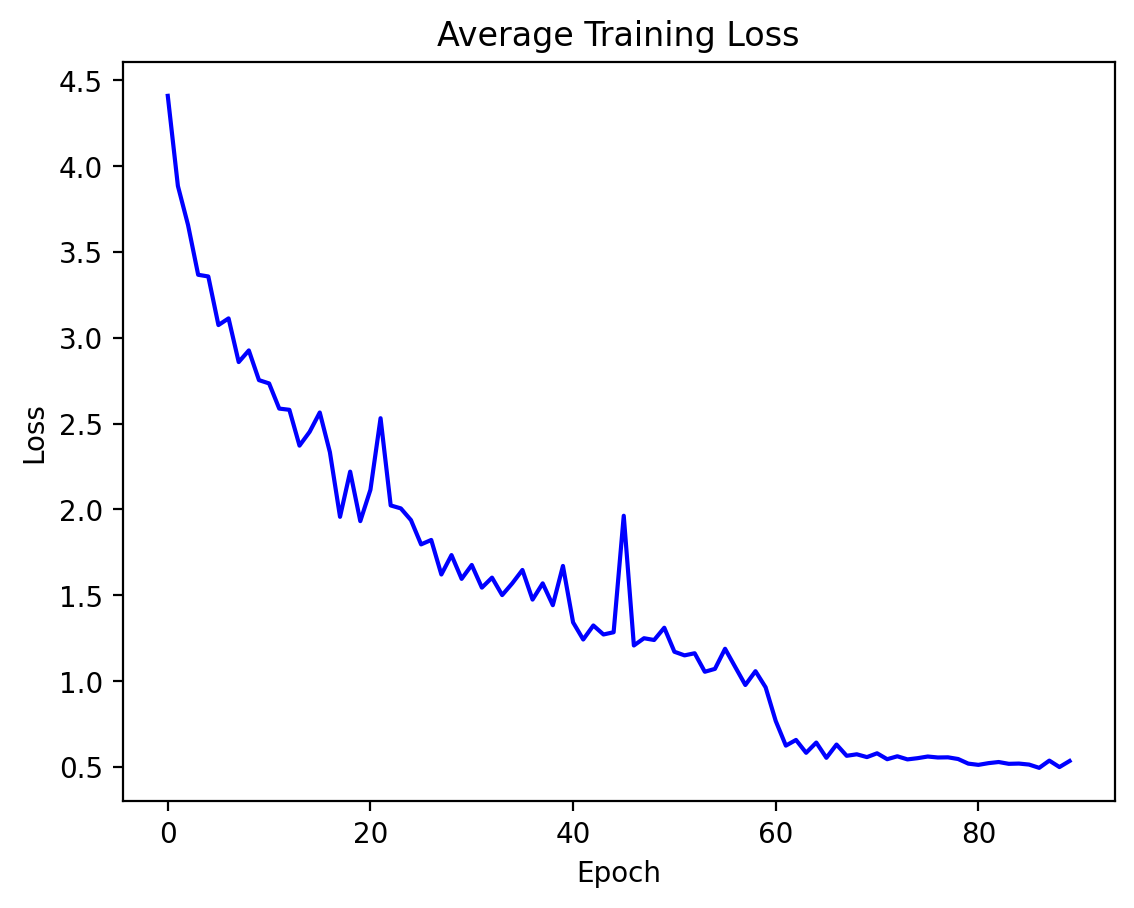

In [112]:
# tell wandb to get started
run = wandb.init(project=project_name, config=config, save_code=True, mode=test_code)

# access all HPs through wandb.config, so logging matches execution!
config = run.config

# make the model, data, and optimization problem
model_ft, criterion, optimizer, scheduler = make(config)

# and use them to train the model
model_ft = train_model(model_ft, criterion, optimizer, scheduler, config)

test_model(model_ft, criterion)

# visualize_model(model_ft)

## Display the confusion matrix as a heatmap

In [113]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
preds = np.zeros((1))
truth = np.zeros((1))

model_ft.eval()
with torch.no_grad():
    for i, data in enumerate(dataloaders['test']):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_ft(images.to(device))
        pred = outputs.argmax(dim=1)
        preds = np.concatenate([preds, pred.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.cpu().numpy()], axis=0)

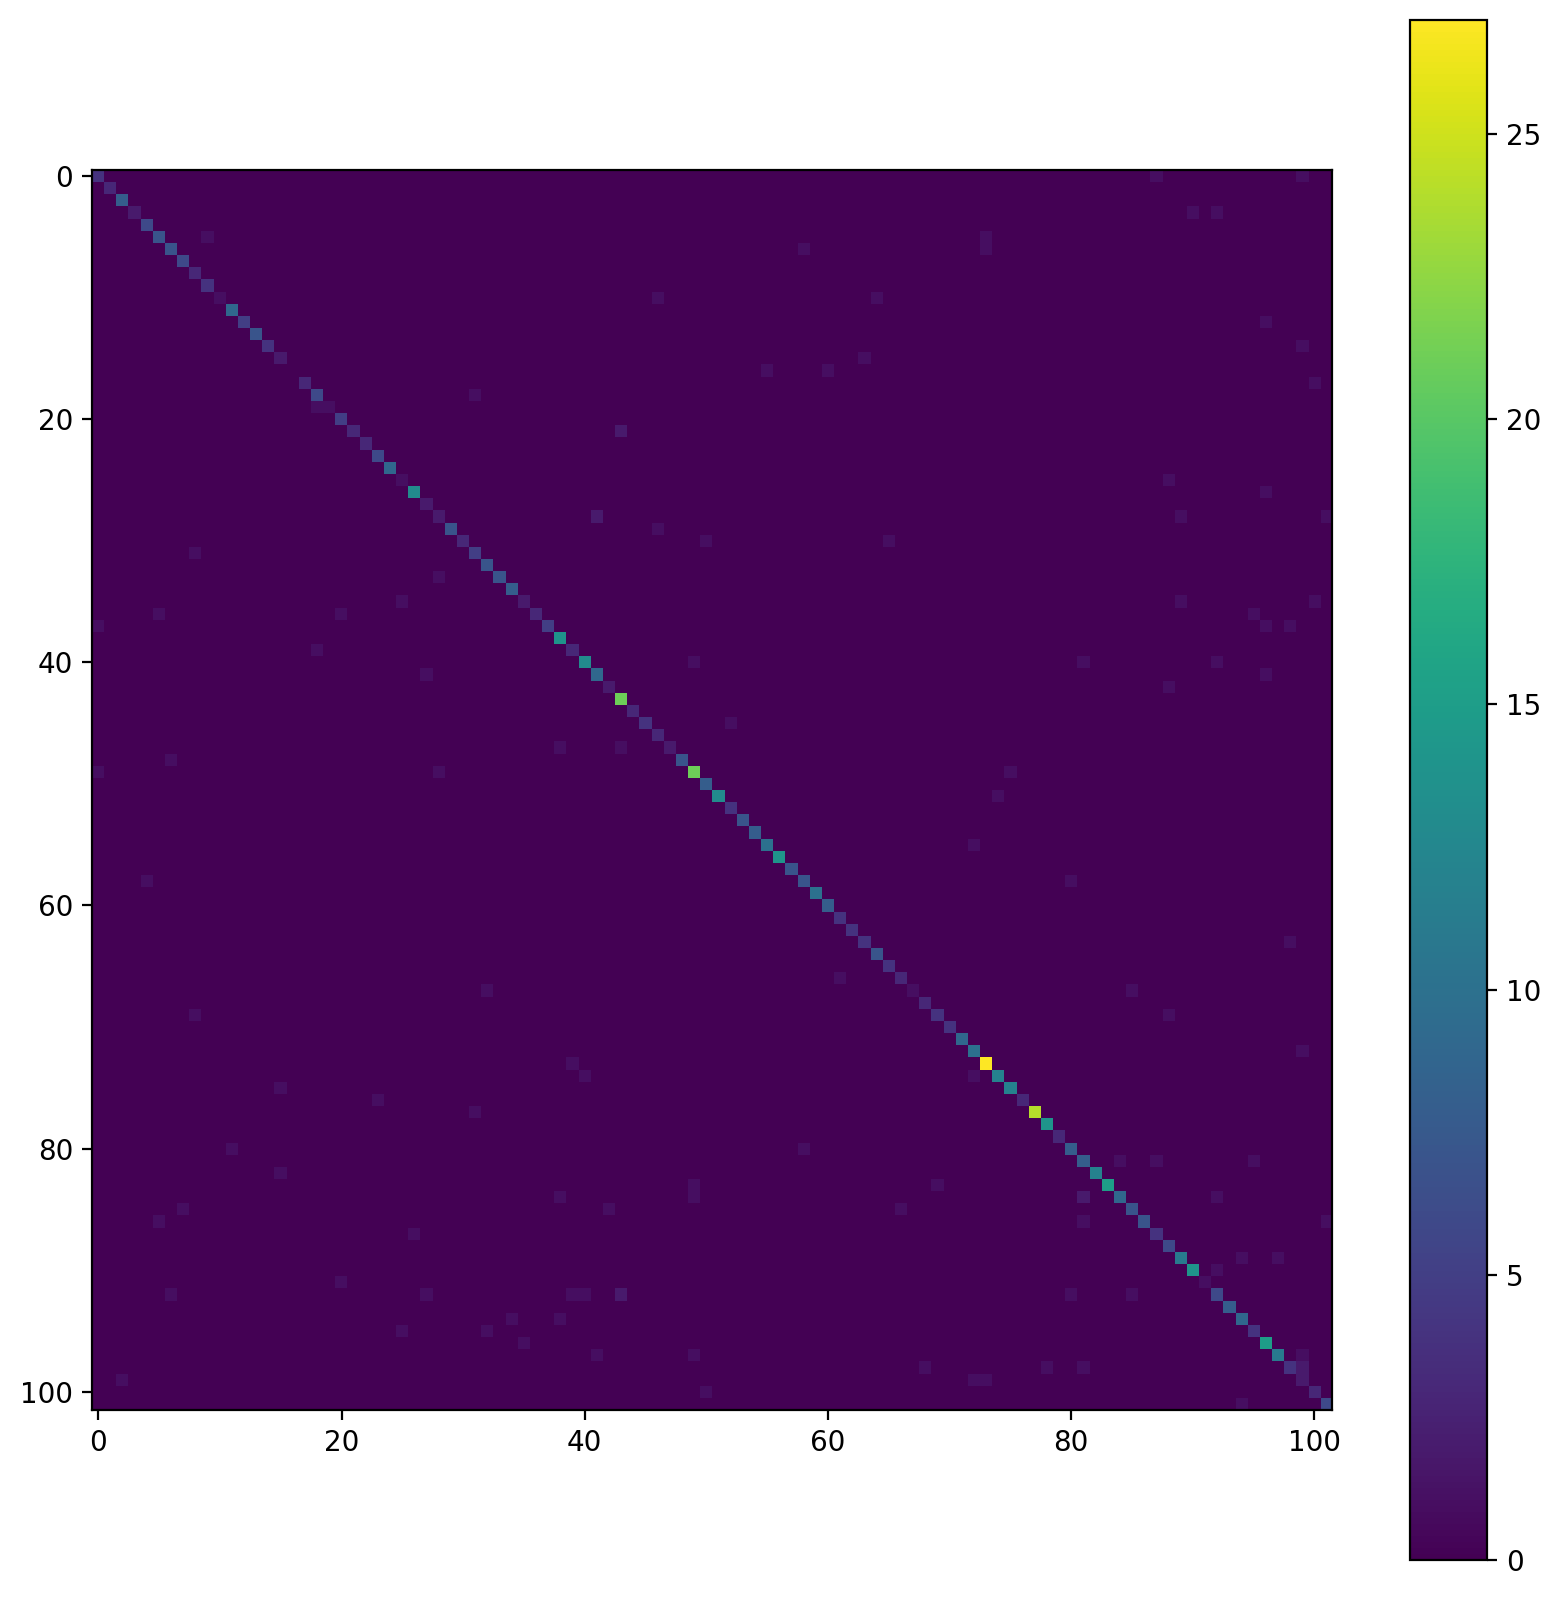

In [114]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import PIL.Image as Image
import io
# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
fig = plt.figure(figsize=(10,10))
plt.imshow(arr)
plt.colorbar()

## Some multi-class performance report defined from Scikit-learn

In [115]:
from sklearn.metrics import classification_report
print(classification_report(truth, preds, target_names=class_names, zero_division=0))

                           precision    recall  f1-score   support

            pink primrose       0.67      0.67      0.67         6
            globe thistle       1.00      1.00      1.00         3
           blanket flower       0.89      1.00      0.94         8
          trumpet creeper       1.00      0.50      0.67         4
          blackberry lily       0.86      1.00      0.92         6
               snapdragon       0.78      0.78      0.78         9
              colt's foot       0.78      0.78      0.78         9
              king protea       0.86      1.00      0.92         6
            spear thistle       0.60      1.00      0.75         3
              yellow iris       0.80      1.00      0.89         4
             globe-flower       1.00      0.33      0.50         3
        purple coneflower       0.90      1.00      0.95         9
            peruvian lily       1.00      0.83      0.91         6
           balloon flower       1.00      1.00      1.00     

In [116]:
run.finish()

Average_training_loss,█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
training time(s),▁
valid accuracy,▁▂▂▃▃▃▄▃▅▄▅▅▅▅▆▆▆▅▆▆▅▆▆▆▆▇▇█████████████
Average_training_loss,0.49937
training time(s),6166.6171
valid accuracy,0.85697
